<a href="https://www.coursera.org/learn/applying-data-analytics-business-in-finance"> <img src="./resources/illinois_banner.png" alt="applying-data-analytics-business-in-finance"/> </a>

# Modern Portfolio Theory, Diversification and Algorithmic Trading

*This lab was developed by:* <br> 
* *Jose Luis Rodriguez, Director of Margolis Market Information Lab, R.C. Evans Innovation Fellow at Gies College of Business*
* *Harsha Talakad Rajashekara, MSF*

On this lab we will introduce some basic measurements of modern portfolio theory. Learn more about risk and returns, how to balance them, and how to evaluate an investment portfolio: 

* Develop an understanding of modern portfolio measurements: what, why, and how to apply them in financial analysis
* Identify opportunities for making investment opportunities through identifying risks and returns and through visualizing efficient frontier
* Understand the benefits of diversification

### Packages and Configurations

* tidyverse: https://www.tidyverse.org/
* lubridate: https://lubridate.tidyverse.org/
* forecast: https://cran.r-project.org/web/packages/forecast/
* xts: https://cran.r-project.org/web/packages/xts

In [1]:
# SUPPRESS PACKAGE WARNINGS
quietly <- suppressPackageStartupMessages

# DISABLE SCIENTIFIC NOTATION
options(scipen = 9999)

# LOAD PACKAGES SUPRESS WARNINGS
quietly(library(xts))
quietly(library(tidyverse))
quietly(library(lubridate))
quietly(library(forecast))
quietly(library(readxl))
quietly(library(TTR))

### Data Import and Exploration

First we load the dataset snpcomposite1500 which contains the constituents of the SnP Composite 1500 

In [2]:
snpcomposite = read_excel("data/snpcomposite1500.xlsx")
head(snpcomposite)

Company Name,Ticker Symbol,Sector
<chr>,<chr>,<chr>
3D Systems Corporation,DDD,"Technology Hardware, Storage and Peripherals"
3M Company,MMM,Industrial Conglomerates
"8x8, Inc.",EGHT,Application Software
A. O. Smith Corporation,AOS,Building Products
"AAON, Inc.",AAON,Building Products
AAR Corp.,AIR,Aerospace and Defense


Second, we load the dataset which contains the stock price data for all the stocks in the S&P Composite 1500

In [3]:
snp1500stockrpices = read.csv("data/snp1500stockprices.csv")

#We will remove the auto-generated row numbers
snp1500stockrpices = snp1500stockrpices[, -1]

head(snp1500stockrpices)

,Date,DDD,MMM,EGHT,AOS,AAON,AIR,AAN,ABT,ABBV,⋯,XYL,YELP,YETI,YUM,ZBRA,ZBH,ZION,ZTS,ZUMZ,ZYXI
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>
1,2007-01-03,5.070000,54.49401,1.16,2.890918,4.523807,26.42558,16.24748,13.68007,NA,⋯,NA,NA,NA,16.20284,34.88,71.53656,69.34019,NA,31.05,0.141456
2,2007-01-04,4.926667,54.27815,1.25,2.873770,4.579867,26.18248,16.40676,13.93986,NA,⋯,NA,NA,NA,16.15880,34.68,73.13244,69.64959,NA,32.44,0.141456
3,2007-01-05,4.833333,53.90908,1.25,2.826225,4.459252,25.34514,16.16465,13.93986,NA,⋯,NA,NA,NA,16.01839,34.33,73.08606,69.44049,NA,32.57,0.174100
4,2007-01-08,4.846667,54.02746,1.50,2.827783,4.501722,25.51622,16.37491,13.99015,NA,⋯,NA,NA,NA,15.97986,34.40,72.61287,69.55762,NA,32.95,0.174100
5,2007-01-09,4.860000,54.09013,1.42,2.833239,4.515313,25.23710,16.25385,14.11306,NA,⋯,NA,NA,NA,16.04043,34.34,72.65925,69.94231,NA,33.94,0.174100
6,2007-01-10,4.986667,54.20849,1.37,2.812974,4.503423,25.23710,16.25385,14.25018,NA,⋯,NA,NA,NA,16.23361,34.37,72.41801,70.35207,NA,35.29,0.136016


Since we will be working with time series data, it is better to convert the 'Date' column to 'Date' format. The Date column is currently in 'Character' format We will use the as_date() function to convert that to 'Date' format

In [4]:
snp1500stockrpices$Date = as_date(snp1500stockrpices$Date)
snpcomposite$Sector = as_factor(snpcomposite$Sector)

We can explore the different sectors in among the constituents

In [5]:
snpcomposite  %>% count(Sector, sort = TRUE)  %>% head(10)

Sector,n
<fct>,<int>
Regional Banks,88
Health Care Equipment,44
Industrial Machinery,41
Oil and Gas Exploration and Production,31
Application Software,28
Semiconductors,28
Retail REITs,27
Property and Casualty Insurance,27
Packaged Foods and Meats,26


## Security Selection

For the first excercise, we will focus on a particular sector and build a portfolio consisting of stocks from the same sector. Here we will select the 'Semiconductor' sector

In [6]:
select_sector <- snpcomposite %>%
                filter(snpcomposite$Sector == "Semiconductors")

Now, we will select 5 random stocks from the chosen sector to build a portfolio. We will extract the stock price data for each of the stocks from Yahoo Finance

In [7]:
set.seed(484)
n = 5

In [8]:
stockpic1 = sample(nrow(select_sector),
                    n,
                    replace = FALSE)

In [9]:
stocklist1 = select_sector[stockpic1, ]
stockprice1 = snp1500stockrpices[, c("Date", stocklist1$`Ticker Symbol`)]

Let us examine the data before we remove any missing data. If we see any stock that has more than 70% of its data missing, we will remove that stock from the portfolio

In [10]:
sapply(stockprice1,
       function(x) sum(is.na(x)))

select_stock = colSums(is.na(stockprice1)) < nrow(stockprice1)
stockprice1 = stockprice1[ , select_stock]

Date INTC SWKS  MXL QCOM AVGO 
   0    0    0  811    0  653

Now, we will rename the columns to reflect the name of the company also remove data for all the stocks for days in which there was no data avaiable 

In [11]:
colnames(stockprice1) <- c("Date", stocklist1$`Company Name`)
       
stockprice1 <- na.omit(stockprice1)

Now, we will convert the dataframe into a time-series data set using xts() function

In [12]:
stockprice1 <- xts(stockprice1[,-1], order.by = stockprice1$Date)

Since we will be working with returns, let us convert the price data to returns 

In [13]:
portfolio_one <- na.omit(diff(log(stockprice1)))

Trimming the Data to get recent data post 12-31-2014 Some stocks might have 

In [14]:
portfolio_one <- portfolio_one["2015/"]
head(portfolio_one)

           Intel Corporation Skyworks Solutions, Inc. MaxLinear, Inc.
2015-01-02       0.001926786              0.008354288     0.006724975
2015-01-05      -0.011339846             -0.016363170     0.017276177
2015-01-06      -0.018813110             -0.032406289    -0.043075300
2015-01-07       0.020758424              0.016334119     0.015017347
2015-01-08       0.018429923              0.044366271     0.045040725
2015-01-09       0.001906021             -0.001618634     0.033124047
           QUALCOMM Incorporated Broadcom Inc.
2015-01-02         -0.0006731744  -0.004983105
2015-01-05         -0.0047231760  -0.016114952
2015-01-06         -0.0143048553  -0.023005797
2015-01-07          0.0115958194   0.026654397
2015-01-08          0.0105237471   0.048766250
2015-01-09         -0.0012085719   0.010637805

## Modern Portfolio Theory: 

### Risk-Return of a Security: Lets calculate the mean and variance for the stock prices

In [15]:
portfolio_means = colMeans(portfolio_one)
portfolio_vars = sapply(portfolio_one, function(x) var(x))

We will combine the column vectors created above to create a dataframe 

In [16]:
stock_plot = as.data.frame(t(cbind(portfolio_vars,
                                    portfolio_means)))

colnames(stock_plot) = colnames(portfolio_one)

We transpose the data frame to get the stock as the observations and the parameters as the columns 

In [17]:
stock_plot = t(stock_plot)

Now, we can plot the risk/return of each of the individual stocks. This will give us a good idea of how the stocks differ in their risk/return profiles

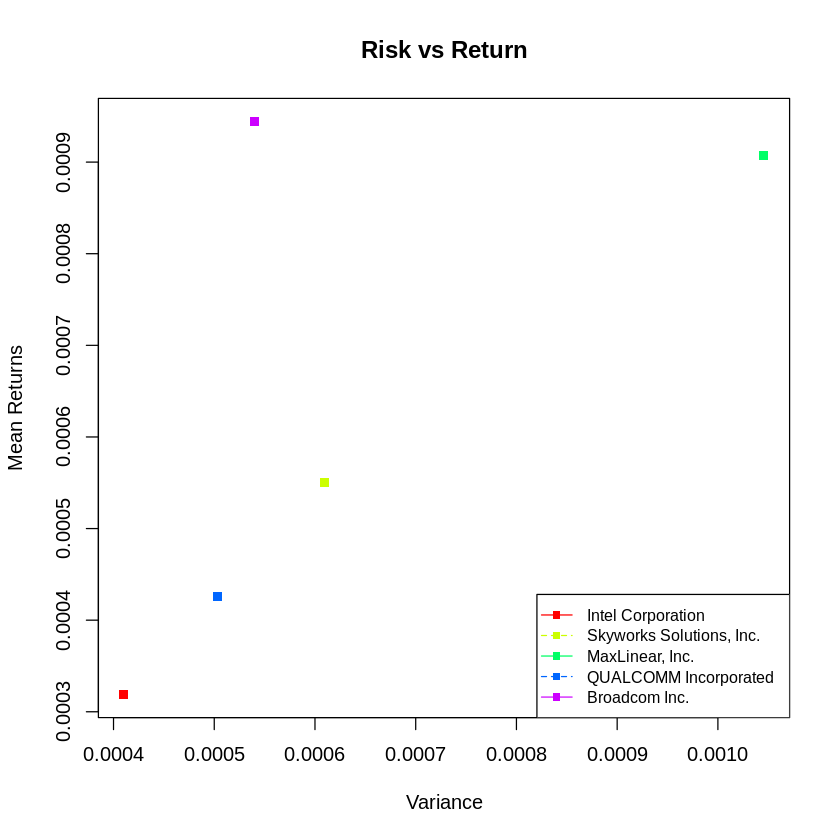

In [18]:
plot(stock_plot, col = rainbow(5), pch= 15,
     xlab = "Variance", ylab = "Mean Returns",
     main = "Risk vs Return")

legend("bottomright", legend = rownames(stock_plot), col = rainbow(5),
       lty = 1:2, cex = 0.8, pch = 15)

### Weights for the Portfolio

We will generate random weights for the portfolio using the runif() function. For this purpose, we will create a function of our own which will create weights for each portfolio such that the sum of the weights is equal to 1. We can generate as many portfolios as needed by changing the value of m.

In [19]:
rand_val <- function(past_values)
{
  if(is.null(past_values))
    past_values = 0
  return(runif(1,0,1-sum(past_values, na.rm = T)))
  
}

In [20]:
n1 = ncol(portfolio_one)
m = 10000

values <- matrix(nrow = m, ncol = n1)

for(j in 1:m){
  for(i in 1:n1)
  {
    if(i == n1)
      values[j,n1] = 1 - sum(values[j,], na.rm = T)
    else
      values[j,i] = rand_val(values[j,])
  }
  
}

values[is.na(values)] <- 0

### Risk and Return for each portfolio

Now that we have the weights for the portfolios, we can generate the returns and risk for each of the portfolios.

The returns of the portfolios are a simple multiplication of the weights and the mean returns of each of the stocks over the given time period


In [21]:
portfolio_returns <- values %*% (portfolio_means)

The risk of the portfolios are a bit more complicated to calculate. Since we have multiple assets, we need to look at the covariance of each pair of assets and then calculate the risk of the portfolio. Such a process will be made easier by creating out own function

In [22]:
pvar <- function(x, weights, na.rm = TRUE) {
c <- var(x)
d <- upper.tri(c)
wt.var <- rowSums(t(weights^2) * diag(c))
wt.cov <- sum(weights[row(c)[d]] *
                weights[col(c)[d]] *
                c[d])
std <- sqrt(wt.var + 2 * wt.cov)
return(std)
}

In [23]:
portfolio_sd <- c()

for (i in 1:nrow(values)) {
  portfolio_sd[i] <- pvar(portfolio_one, values[i,])  
}

Now, let us put the risk and returns of the portfolio in a single data frame

In [24]:
portfolios <- as.data.frame(cbind(portfolio_returns, portfolio_sd))
colnames(portfolios) <- c("Returns", "Standard Deviation")
head(portfolios)

,Returns,Standard Deviation
,<dbl>,<dbl>
1,0.0004425735,0.01918058
2,0.0004761117,0.01859703
3,0.0006201264,0.02038517
4,0.0005419368,0.02007144
5,0.0005247766,0.01989968
6,0.0004137468,0.01930736


### Efficient Frontier

We can now plot the efficient frontier using the risk and return datapoints.

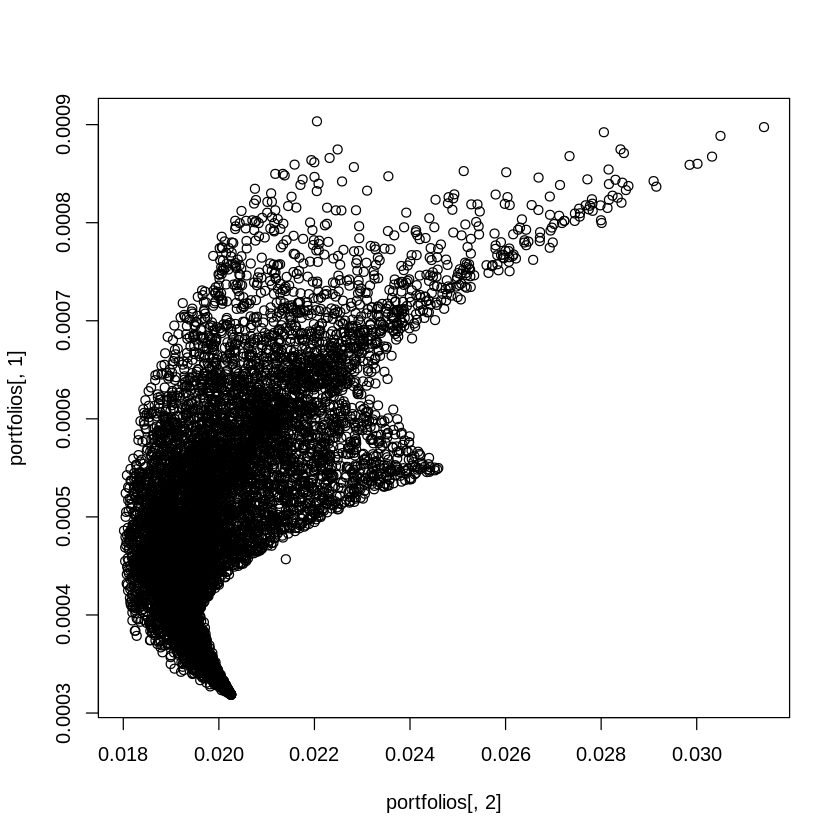

In [25]:
plot(x = portfolios[,2], y = portfolios[,1])

### Sharpe Ratio: We can calculate the Sharpe ratio for all the portfolios

In [26]:
portfolios <- portfolios %>% 
  mutate(sharpe_ratio = ((1+portfolios[,1])^252 - 1) / (portfolios[,2]*sqrt(252)))
head(portfolios)

,Returns,Standard Deviation,sharpe_ratio
,<dbl>,<dbl>,<dbl>
1,0.0004425735,0.01918058,0.3874054
2,0.0004761117,0.01859703,0.4316877
3,0.0006201264,0.02038517,0.5225125
4,0.0005419368,0.02007144,0.4591318
5,0.0005247766,0.01989968,0.4474451
6,0.0004137468,0.01930736,0.3584717


We can obtain the minimum variance portfolio and the tangency portfolio by looking at the lowest standard deviation portfolio
and the highest Sharpe Ratio portfolio

### Minimum variance portfolio

In [27]:
#Weights
values[which.min(portfolios[,2]),]

#Return, Risk and Sharpe
portfolios[which.min(portfolios[,2]),]

[1] 0.470126059 0.007148173 0.002963025 0.311186281 0.208576462

,Returns,Standard Deviation,sharpe_ratio
,<dbl>,<dbl>,<dbl>
8775,0.0004860142,0.01801462,0.4554898


### Tangency Portfolio

In [28]:
#Weights
values[which.max(portfolios[,3]),]
#Return, Risk and Sharpe for the optimal portfolio is

tangency_sharpe <- portfolios[which.max(portfolios[,3]),]
tangency_sharpe

[1] 0.005957427 0.010920094 0.281382945 0.043431774 0.658307761

,Returns,Standard Deviation,sharpe_ratio
,<dbl>,<dbl>,<dbl>
1372,0.0009033798,0.02205265,0.7298976


### Comparison of weight of each stock in the Minimum Variance Portfolio and the Tangency Portfolio

In [29]:
minvar_weights <- values[which.min(portfolios[,2]),]
tangency_weights <- values[which.max(portfolios[,3]),]
port_weights <- cbind(minvar_weights, tangency_weights)
rownames(port_weights) <- colnames(portfolio_one)
head(port_weights)

,minvar_weights,tangency_weights
Intel Corporation,0.470126059,0.005957427
"Skyworks Solutions, Inc.",0.007148173,0.010920094
"MaxLinear, Inc.",0.002963025,0.281382945
QUALCOMM Incorporated,0.311186281,0.043431774
Broadcom Inc.,0.208576462,0.658307761


We can see that for the tangency portfolio, the majority of the weightage is given to two stocks - MaxLinear and Broadcom. 
If we look at the risk return plot we did for the individual stocks, we can see that these two stocks had the highest 
returns while being not too risky compared to the other stocks.

# Diversification

Thus far, we have seen how the portfolio construction work for a basket of stocks from the same sector. This might not be an ideal way to construct a portfolio, since the portfolio is completely weighted with stocks from the same sector and hence exposed to a lot of risk. To minimize this risk, we diversify - a process of tatical risk allocation to minimze portfolio risk.

We will select random stocks from the the list of stocks in the SnP Composite1500 and form an efficient frontier from them. 
We will then compare the Sharpe ratios of the same sector portfolio and two diversified portfolios to see how diversification 
impacts the risk-reward of a portfolio.

### Divesified Portfolio with 10 Stocks

First, we will look at a portfolio that is contructed by taking 10 random stocks from the SnP Composite

The process to download the data is similar to the one showed above except that we are not restricted to any particular sector
to select the stocks from. So we will select 10 random stocks from the list of stocks in the SnP Composite 1500

In [30]:
set.seed(484)
m <- 15

In [31]:
stockpic2 <- sample(nrow(snpcomposite), m, replace = FALSE)
stocklist2 <- snpcomposite[stockpic2, ]

stockprice_div10 <- snp1500stockrpices[, 
                                       c("Date",
                                         stocklist2$`Ticker Symbol`)]

colnames(stockprice_div10) <- c("Date", stocklist2$`Company Name`)

sapply(stockprice_div10, function(x) sum(is.na(x)))

Date         Commvault Systems, Inc. 
                              0                               0 
        Customers Bancorp, Inc.                 AMERISAFE, Inc. 
                           3422                               0 
            Arconic Corporation         Lantheus Holdings, Inc. 
                           3422                            3422 
                KLA Corporation            Cincinnati Bell Inc. 
                              0                               0 
Motorcar Parts of America, Inc.                FormFactor, Inc. 
                              0                               0 
                   Hasbro, Inc.         DuPont de Nemours, Inc. 
                              0                               0 
  Standard Motor Products, Inc.                     AbbVie Inc. 
                              0                            3422 
                 MYR Group Inc.                  L Brands, Inc. 
                            406                               0

We can see that some of the stocks have no price data for the entire time period. In such a case, we can remove the column and proceed with the portfolio construction.

In [32]:
stockprice_div10 <- stockprice_div10[, colSums(is.na(stockprice_div10)) < nrow(stockprice_div10)]

In [33]:
stockprice_div10 <- na.omit(stockprice_div10)
stockprice_div10 <- xts(stockprice_div10[,-1],
                        order.by = stockprice_div10$Date)

portfolio_two <- na.omit(diff(log(stockprice_div10)))
portfolio_two <- portfolio_two["2015/"]

### Efficient Frontier construction for portfolios with 11 random stocks

In [34]:
set.seed(484)
rand_val <- function(past_values)
{
  if(is.null(past_values))
    past_values = 0
  return(runif(1, 0, 1 - sum(past_values, na.rm = T)))
  
}

In [35]:
n2 = ncol(portfolio_two)
m = 10000

values2 <- matrix(nrow = m, ncol = n2)

for(j in 1:m){
  for(i in 1:n2)
  {
    if(i == n2)
      values2[j,n2] = 1 - sum(values2[j,], na.rm = T)
    else
      values2[j,i] = rand_val(values2[j,])
  }
  
}

values2[is.na(values2)] <- 0

In [36]:
portfolio_two_mean <- colMeans(portfolio_two)
portfolio2_returns <- values2 %*% (portfolio_two_mean)

In [37]:
pvar2 <- function(x, weights, na.rm = TRUE) {
    c <- var(portfolio_two)
    d <- upper.tri(c)

    wt.var <- rowSums(t(weights^2) * diag(c))
    wt.cov <- sum(weights[row(c)[d]] *
                    weights[col(c)[d]] *
                    c[d])
    std <- sqrt(wt.var + 2 * wt.cov)
    return(std)
}

In [38]:
portfolio2_sd <- c()
for (i in 1:nrow(values2)) {
  portfolio2_sd[i] <- pvar2(portfolio_two, values2[i,])  
}

Now, let us put the risk and returns of the portfolio in a single data frame

In [39]:
portfolios_two <- as.data.frame(cbind(portfolio2_returns, portfolio2_sd))

In [40]:
colnames(portfolios_two) <- c("Returns", "Standard Deviation")
head(portfolios_two)

,Returns,Standard Deviation
,<dbl>,<dbl>
1,0.000502952016,0.01490623
2,0.000048551975,0.01669546
3,0.000388361581,0.01456647
4,-0.000024920255,0.01857419
5,0.000005516205,0.01811476
6,0.000023506036,0.01701958


In [41]:
portfolios_two <- portfolios_two %>% 
  mutate(sharpe_ratio = ((1+portfolios_two[,1])^252 - 1) / (portfolios_two[,2]*sqrt(252)))

In [42]:
head(portfolios_two)

,Returns,Standard Deviation,sharpe_ratio
,<dbl>,<dbl>,<dbl>
1,0.000502952016,0.01490623,0.570894038
2,0.000048551975,0.01669546,0.046447017
3,0.000388361581,0.01456647,0.444547819
4,-0.000024920255,0.01857419,-0.021231723
5,0.000005516205,0.01811476,0.004837365
6,0.000023506036,0.01701958,0.021989368


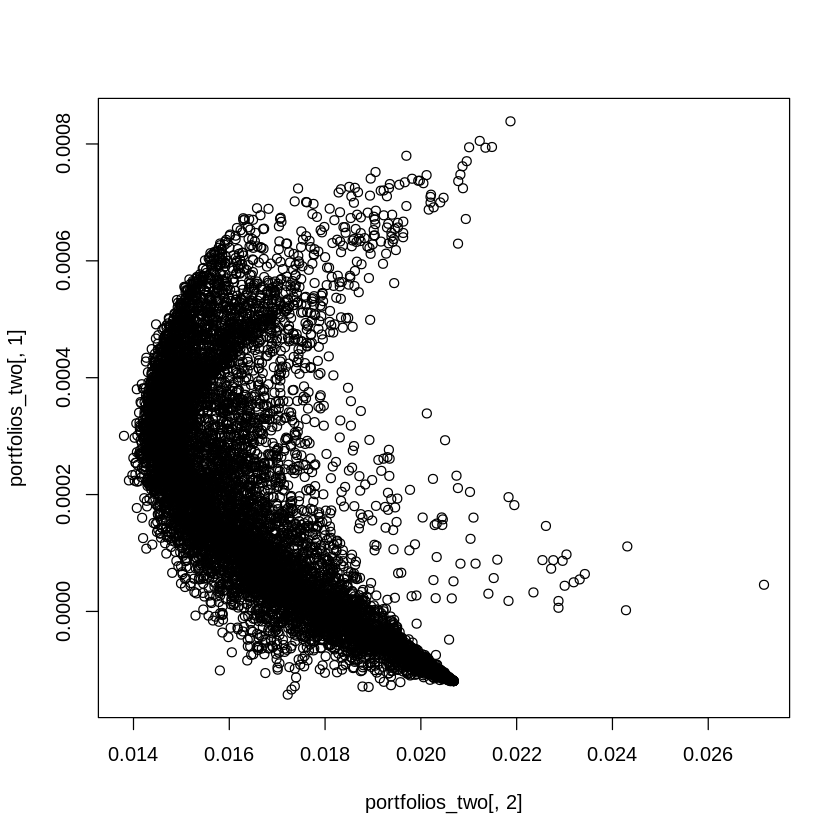

In [43]:
plot(x = portfolios_two[,2], y = portfolios_two[,1])

### Optimal Portfolio for diversified portfolio

In [44]:
tangency_sharpe2 <- portfolios_two[which.max(portfolios_two[,3]),]
tangency_sharpe2

,Returns,Standard Deviation,sharpe_ratio
,<dbl>,<dbl>,<dbl>
5147,0.0007238057,0.01743633,0.7226109


### Divesified Portfolio with 20 Stocks

Now let us try the same for 20 stocks and check if there are any changes in the risk-reward profile

In [45]:
set.seed(484)
p <- 20

In [46]:
stockpic3 <- sample(nrow(snpcomposite), p, replace = FALSE)
stocklist3 <- snpcomposite[stockpic3,]
stockprice_div20 <- snp1500stockrpices[,
                                       c("Date",
                                         stocklist3$`Ticker Symbol`)]
colnames(stockprice_div20) <- c("Date", stocklist3$`Company Name`)
sapply(stockprice_div20, function(x) sum(is.na(x)))

Date         Commvault Systems, Inc. 
                              0                               0 
        Customers Bancorp, Inc.                 AMERISAFE, Inc. 
                           3422                               0 
            Arconic Corporation         Lantheus Holdings, Inc. 
                           3422                            3422 
                KLA Corporation            Cincinnati Bell Inc. 
                              0                               0 
Motorcar Parts of America, Inc.                FormFactor, Inc. 
                              0                               0 
                   Hasbro, Inc.         DuPont de Nemours, Inc. 
                              0                               0 
  Standard Motor Products, Inc.                     AbbVie Inc. 
                              0                            3422 
                 MYR Group Inc.                  L Brands, Inc. 
                            406                               0 
    Prosperity Bancshares, Inc.                Hess Corporation 
                              0                               0 
           Conagra Brands, Inc.        Tyler Technologies, Inc. 
                              0                               0 
          Univar Solutions Inc. 
                           3422

In [47]:
stockprice_div20 <- stockprice_div20[,
                                     colSums(is.na(stockprice_div20))<nrow(stockprice_div20)]
stockprice_div20 <- xts(stockprice_div20[,-1],
                        order.by = stockprice_div20$Date)
Portfolio3 <- na.omit(diff(log(stockprice_div20)))
Portfolio3 <- Portfolio3["2015/"]

In [48]:
rand_val <- function(past_values)
{
  if(is.null(past_values))
    past_values = 0
  return(runif(1,0,1-sum(past_values, na.rm = T)))
  
}

n2 = ncol(Portfolio3)
m = 10000

values3 <- matrix(nrow = m, ncol = n2)

for(j in 1:m){
  for(i in 1:n2)
  {
    if(i == n2)
      values3[j,n2] = 1- sum(values3[j,], na.rm = T)
    else
      values3[j,i] = rand_val(values3[j,])
  }
  
}

In [49]:
values3[is.na(values3)] <- 0    
mean3 <- colMeans(Portfolio3)
portfolio3_returns <- values3 %*% (mean3)

In [50]:
pvar3 <- function(x, weights, na.rm = TRUE) {
    c <- var(Portfolio3)
    d <- upper.tri(c)
    wt.var <- rowSums(t(weights^2) * diag(c))
    wt.cov <- sum(weights[row(c)[d]] *
                    weights[col(c)[d]] *
                    c[d])
    std <- sqrt(wt.var + 2 * wt.cov)
    return(std)
}

In [51]:
portfolio3_sd <- c()

for (i in 1:nrow(values3)) {
  portfolio3_sd[i] <- pvar3(Portfolio3, values3[i,])  
}

Now, let us put the risk and returns of the portfolio in a single data frame

In [52]:
portfolios3 <- as.data.frame(cbind(portfolio3_returns, portfolio3_sd))
colnames(portfolios3) <- c("Returns", "Standard Deviation")

In [53]:
portfolios3 <- portfolios3 %>% 
  mutate(sharpe_ratio=((1+portfolios3[,1])^252 - 1) / (portfolios3[,2]*sqrt(252)))

In [54]:
head(portfolios3)

,Returns,Standard Deviation,sharpe_ratio
,<dbl>,<dbl>,<dbl>
1,0.00014105063,0.01619669,0.14072105
2,0.00003365954,0.01771757,0.03028588
3,-0.00009654936,0.02004930,-0.07552638
4,0.00024925025,0.01442094,0.28313735
5,0.00041065578,0.01456460,0.47146667
6,0.00024200832,0.01460526,0.27119231


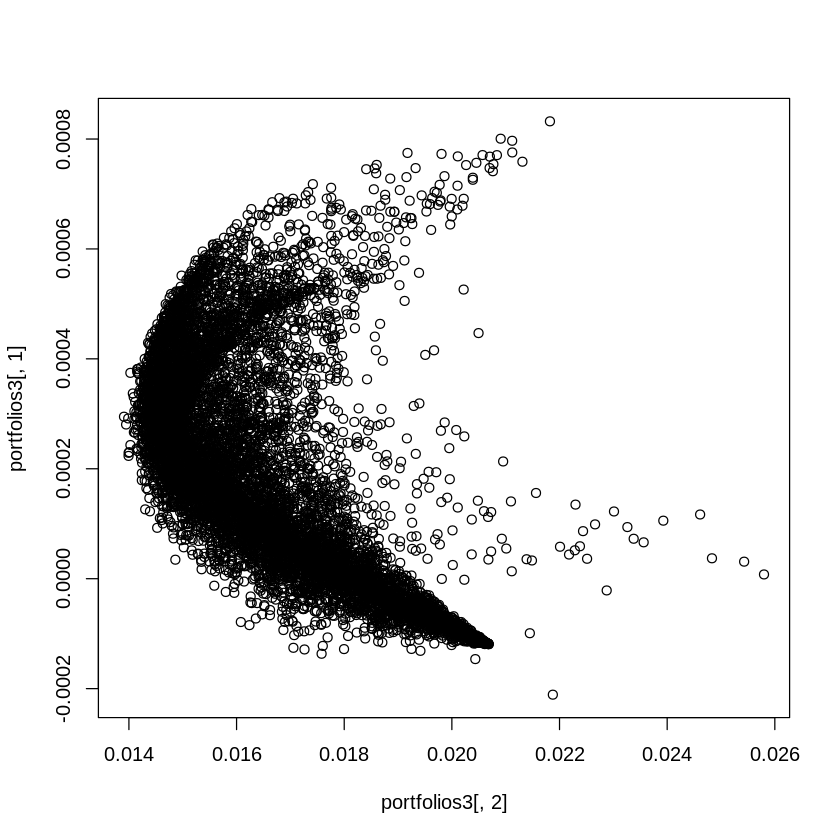

In [55]:
plot(x = portfolios3[,2], y = portfolios3[,1])

In [56]:
tangency_sharpe3 <- portfolios3[which.max(portfolios3[,3]),]
tangency_sharpe3

,Returns,Standard Deviation,sharpe_ratio
,<dbl>,<dbl>,<dbl>
4704,0.0007179324,0.01741727,0.7169876


### Comparison of the 3 Portfolios
Let us compare how the different portfolio performed on a risk-adjusted basis

In [57]:
performance <- data.frame(cbind(t(tangency_sharpe),
                                t(tangency_sharpe2),
                                t(tangency_sharpe3)))

colnames(performance) <- c("Same Sector Portfolio",
                           "Random 10 Stock Portfolio",
                           "20 Random Stock Portfolio")
rownames(performance) <- c("Returns",
                           "StandardDeviation",
                           "SharpeRatio")

head(performance)

,Same Sector Portfolio,Random 10 Stock Portfolio,20 Random Stock Portfolio
,<dbl>,<dbl>,<dbl>
Returns,0.0009033798,0.0007238057,0.0007179324
StandardDeviation,0.0220526517,0.0174363339,0.0174172670
SharpeRatio,0.7298975608,0.7226108996,0.7169875803


In the above table we can see that the Standard Deviation(Risk) for the diversified portfolio with 20 stocks is lower than the other two portfolios. 

## Introduction to Algorithmic Trading

Algorithmic trading uses computer programs to place buy and sell orders automatically according to a specified set of rules. These rules are collectively referred to as the trading algorithm.
In this class, we will focus on a trend following strategy which is based on moving average cross-overs.
This type of a strategy is dependent on the relative position of two moving averages. The longer duration moving average is called the Slow MA and the shorter duration moving average is called the Fast MA.

### Data Import and Exploration

Obtaining stock price data for Advanced Auto Parts Inc

In [58]:
AAP <- snp1500stockrpices[,c("Date","AAP")]
AAP <- xts(AAP[,-1], order.by = AAP$Date)

We will convert the stock price to log returns

In [59]:
AAPret <- diff(log(AAP))
colnames(AAPret)  <- "AAP"

We will trim the dataset to use the data post 12-31-2009

In [60]:
AAPret <- AAPret["2010/"]
AAP <- AAP["2010/"]

We will use the plot() function to create a line plot of the stock price 

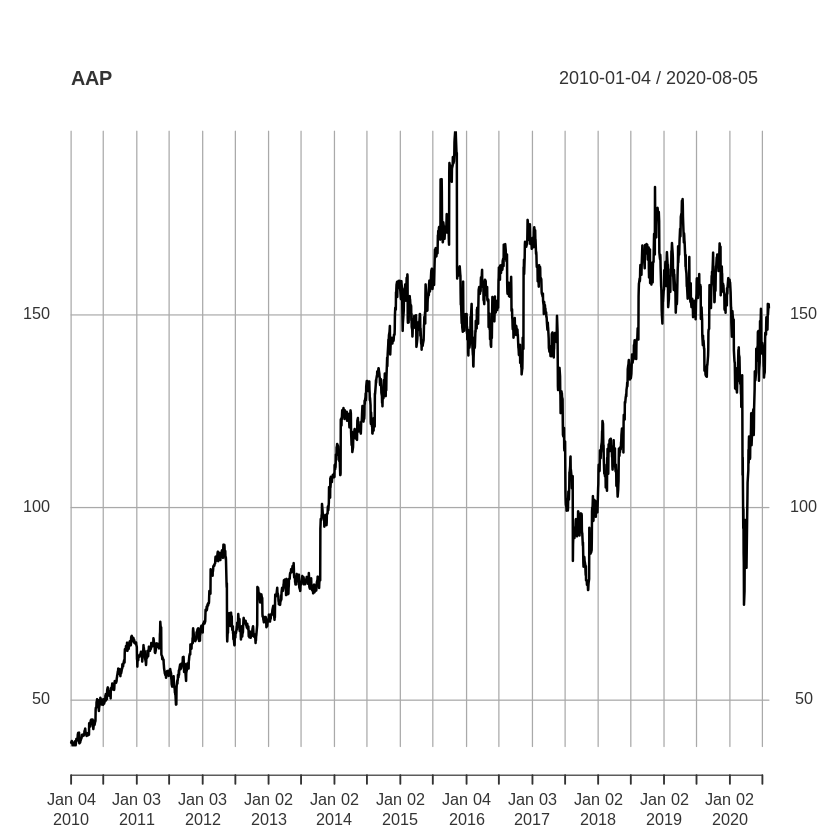

In [61]:
plot(AAP)

### Simple Moving Averages

We will generate the Fast(12 day) and Slow(26 day) Simple Moving Averages for the stock prices


In [62]:
sma26 <- SMA(AAP, 26)
sma12 <- SMA(AAP, 12)

We will put together the price, returns and the moving averages data in a signle data frame for ease of use

In [63]:
Data <- na.omit(as.data.frame(cbind(AAP, AAPret, sma12, sma26)))
colnames(Data) <- c("AAPPrices","AAPRet","SMA12","SMA26" )

We will plot the stock price data along with the moving averages data to see how the variation in stock prices affect the variations in each of the moving averages.

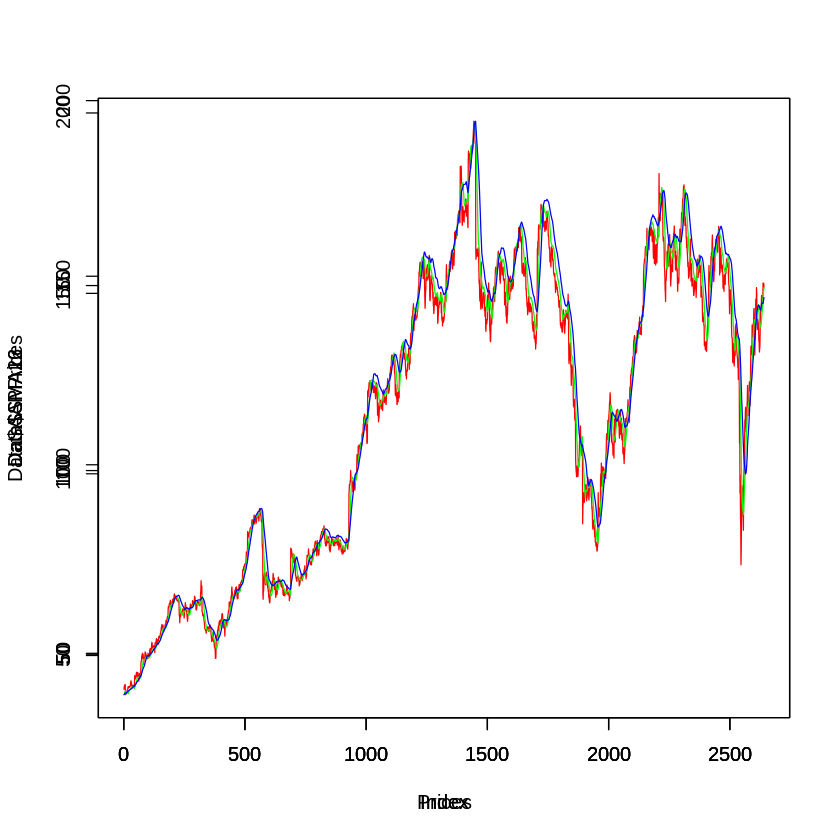

In [64]:
plot(Data$AAPPrices, type = "l", col = "red", xlab = "Prices")
par(new = TRUE)
plot(Data$SMA12, type = "l" , col = "green")
par(new = TRUE)
plot(Data$SMA26, type = "l" , col = "blue")

Here, we can see that the slow moving average(26 day) is much more smoother than the fast moving average(12 day)

### Trend Following Strategy
Condition for trend following strategy

We will create a new columnn in the Data dataframe which tells us the relative position of the slow moving average with respect
to the fast moving average. If the fast moving avergae is higher than the slow moving average, we assign a value of 1 to the column. If not, then a 0.

In [65]:
Data$UD <- ifelse(Data$SMA12 >= Data$SMA26, 1, 0)
class(Data$UD)

[1] "numeric"

### Backtesting
Devise a trading strategy and Backtest

The strategy we will be working with tell us that if the fast moving average is higher than the slow moving average - it indicates an upward short-term pressure. Hence, we assign a BUY signal for this scenario. If the fast moving average is higher than the slow moving average - it indicates an upward short-term pressure. Hence, we assign a BUY signal for this scenario.

In [66]:
Data$Trade <- ifelse(Data$UD == 1, "BUY", "SELL")
Data$Position <- ifelse(Data$Trade == "BUY", 1, -1)

Once we have assigned the singals. We can calculate the returns earned by the our postions i.e. the positions that are initiated according to the signal generated by the moving averages. This is done by multiplying the position with the actual return for the particular day. For example, if the strategy incidicates a Buy for a particular day and we see a positive x% return on that day, we gain x%. Similarly, for Short positions, we gain if the stock has a negative return for the day.

In [67]:
Data$AlgoRet <- Data$AAPRet * Data$Position

Once we have the daily returns for the strategy, we can calculate the annualized returns for the same


In [68]:
AnnualizedReturn <- ((mean(Data$AlgoRet)+1)^252 - 1)

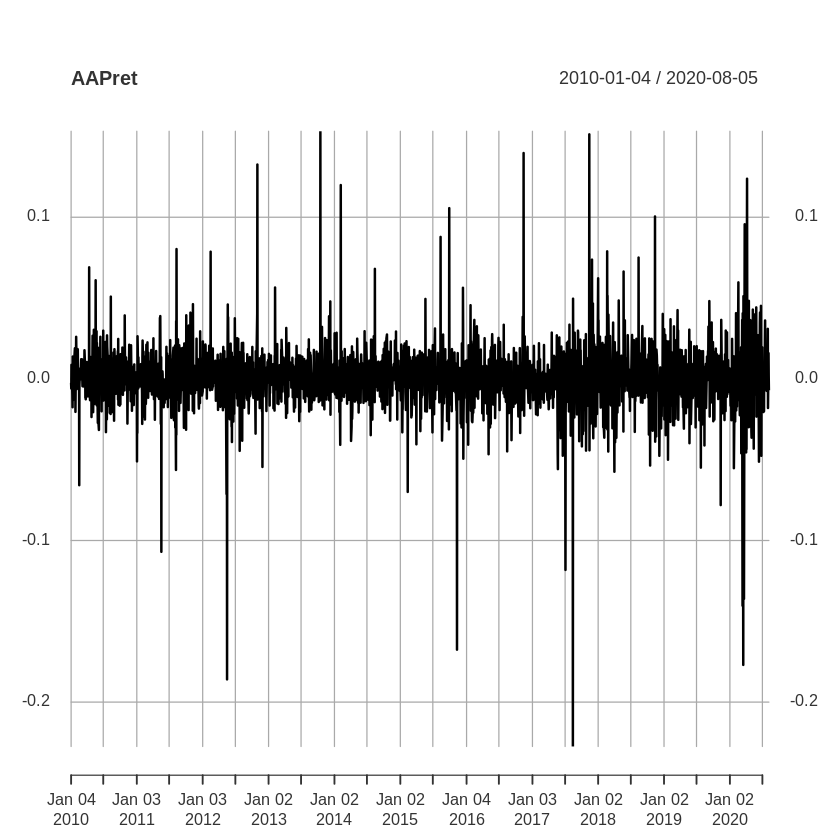

In [69]:
plot(AAPret)

We will also calculate the Standard Deviation for the strategy returns


In [70]:
Standev <- sd(Data$AlgoRet)

Now, to measure the risk adjusted performance of the strategy, we calculate the Sharpe Ratio

In [71]:
rf <- 0.02
SharpeRatio <- (AnnualizedReturn - rf) / (Standev * sqrt(252))

The trend-following algorithm was applied to the AAP Stock prices and was able to achieve an Annualized Return of

In [72]:
AnnualizedReturn

[1] 0.1483549

## Summary

In this lab we learned how to used analytical methods to analyze time series data and build portfolios from scratch. We analyzed the portfolios and were able to optimize them to acheive high risk-adjusted returns.

<a href="https://www.coursera.org/learn/applying-data-analytics-business-in-finance"> <img src="./resources/illinois_banner.png" alt="applying-data-analytics-business-in-finance"/> </a>